In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

# ========================
# 1. Config
# ========================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR = "alphabet_dataset"   # contains train/ and test/
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001
NUM_CLASSES = 29  # A-Z alphabets (change if fewer classes)

# ========================
# 2. Transforms
# ========================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# ========================
# 3. Load Data
# ========================
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transform)
test_dataset  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========================
# 4. Model
# ========================
model = models.resnet18(pretrained=True)   # Transfer learning
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# ========================
# 5. Loss & Optimizer
# ========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# ========================
# 6. Training Loop
# ========================
for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = 100 * correct_train / total_train

    # ---- Test ----
    model.eval()
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    test_acc = 100 * correct_test / total_test

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {running_loss/len(train_loader):.4f} "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

# ========================
# 7. Save Model
# ========================
torch.save(model.state_dict(), "alphabet_classifier.pth")
print("✅ Model saved as alphabet_classifier.pth")


C:\Users\Ahsan Mustafa\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ahsan Mustafa\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Train Loss: 0.1022 Train Acc: 97.01% | Test Acc: 92.86%
Epoch [2/10] Train Loss: 0.0268 Train Acc: 99.22% | Test Acc: 92.86%
Epoch [3/10] Train Loss: 0.0224 Train Acc: 99.34% | Test Acc: 92.86%
Epoch [4/10] Train Loss: 0.0171 Train Acc: 99.52% | Test Acc: 89.29%
Epoch [5/10] Train Loss: 0.0143 Train Acc: 99.59% | Test Acc: 92.86%
Epoch [6/10] Train Loss: 0.0092 Train Acc: 99.73% | Test Acc: 92.86%
Epoch [7/10] Train Loss: 0.0108 Train Acc: 99.71% | Test Acc: 92.86%
Epoch [8/10] Train Loss: 0.0090 Train Acc: 99.74% | Test Acc: 92.86%
Epoch [9/10] Train Loss: 0.0081 Train Acc: 99.79% | Test Acc: 92.86%
Epoch [10/10] Train Loss: 0.0073 Train Acc: 99.83% | Test Acc: 92.86%
✅ Model saved as alphabet_classifier.pth


KeyboardInterrupt: 

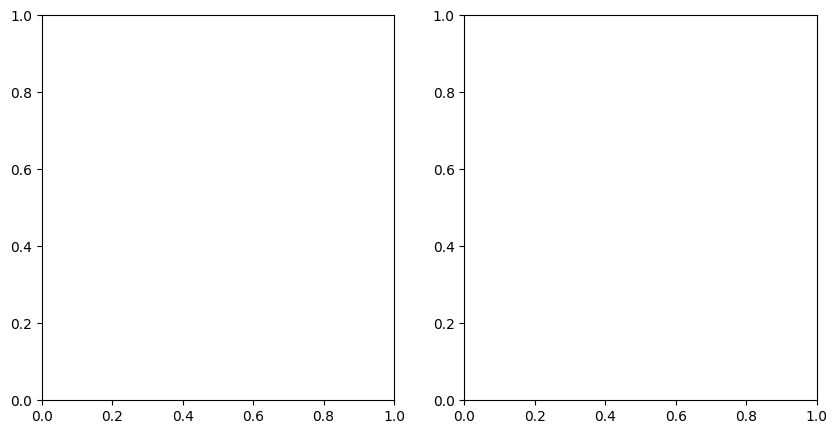

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix

def get_overall_tp_fp_fn_tn(loader):
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            preds = out.argmax(1).cpu().numpy()
            labels = yb.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    cm = confusion_matrix(all_labels, all_preds)

    TP = np.trace(cm)                # all correct predictions
    FP = np.sum(cm.sum(axis=0)) - TP # predicted but wrong
    FN = np.sum(cm.sum(axis=1)) - TP # missed predictions
    TN = np.sum(cm) - (TP + FP + FN)

    print(TP, FP, FN, TN)

    return np.array([[TP, FP],
                     [FN, TN]])

def plot_combined(train_loader, test_loader):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            
    # Train
    cm_train = get_overall_tp_fp_fn_tn(train_loader)
    im1 = axes[0].imshow(cm_train, cmap="Blues")
    for (i, j), val in np.ndenumerate(cm_train):
        axes[0].text(j, i, str(val), ha="center", va="center", fontsize=12, color="black")
    axes[0].set_xticks([0,1], labels=["TP","FP"])
    axes[0].set_yticks([0,1], labels=["FN","TN"])
    axes[0].set_title("Train Dataset")

    # Test
    cm_test = get_overall_tp_fp_fn_tn(test_loader)
    im2 = axes[1].imshow(cm_test, cmap="Reds")
    for (i, j), val in np.ndenumerate(cm_test):
        axes[1].text(j, i, str(val), ha="center", va="center", fontsize=12, color="black")
    axes[1].set_xticks([0,1], labels=["TP","FP"])
    axes[1].set_yticks([0,1], labels=["FN","TN"])
    axes[1].set_title("Test Dataset")

    plt.suptitle("Overall TP / FP / FN / TN", fontsize=16)
    plt.tight_layout()
    plt.show()

# =========================
# Run for Train & Test
# =========================
plot_combined(train_loader, test_loader)


TP: 2997 FP: 0 FN: 0 TN: 3000
TP: 1 FP: 0 FN: 0 TN: 1


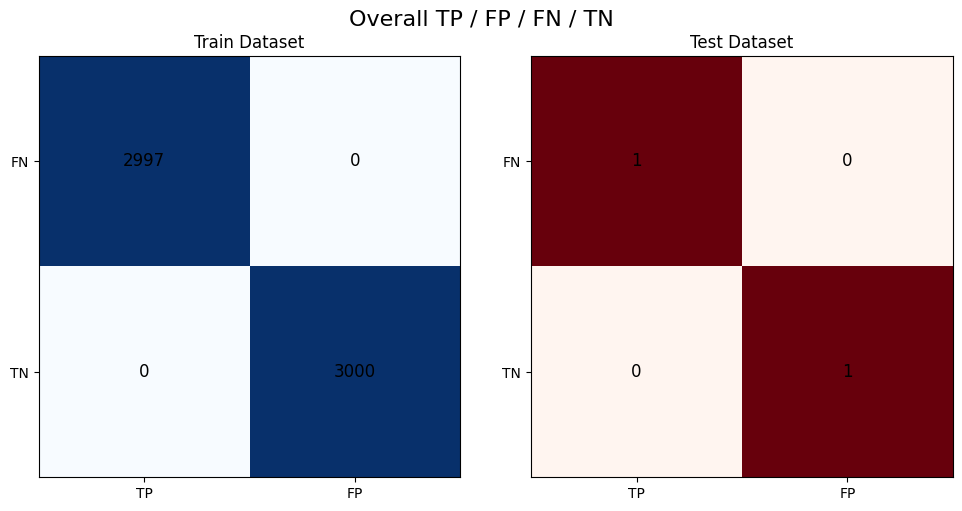

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

def get_overall_tp_fp_fn_tn(loader):
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb)
            preds = out.argmax(1).cpu().numpy()
            labels = yb.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Get confusion matrix (binary: labels [0,1])
    cm = confusion_matrix(all_labels, all_preds, labels=[0,1])
    # cm looks like:
    # [[TN, FP],
    #  [FN, TP]]

    TN, FP, FN, TP = cm.ravel()

    print("TP:", TP, "FP:", FP, "FN:", FN, "TN:", TN)

    return np.array([[TP, FP],
                     [FN, TN]])

def plot_combined(train_loader, test_loader):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Train
    cm_train = get_overall_tp_fp_fn_tn(train_loader)
    im1 = axes[0].imshow(cm_train, cmap="Blues")
    for (i, j), val in np.ndenumerate(cm_train):
        axes[0].text(j, i, str(val), ha="center", va="center", fontsize=12, color="black")
    axes[0].set_xticks([0,1], labels=["TP","FP"])
    axes[0].set_yticks([0,1], labels=["FN","TN"])
    axes[0].set_title("Train Dataset")

    # Test
    cm_test = get_overall_tp_fp_fn_tn(test_loader)
    im2 = axes[1].imshow(cm_test, cmap="Reds")
    for (i, j), val in np.ndenumerate(cm_test):
        axes[1].text(j, i, str(val), ha="center", va="center", fontsize=12, color="black")
    axes[1].set_xticks([0,1], labels=["TP","FP"])
    axes[1].set_yticks([0,1], labels=["FN","TN"])
    axes[1].set_title("Test Dataset")

    plt.suptitle("Overall TP / FP / FN / TN", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_combined(train_loader, test_loader)


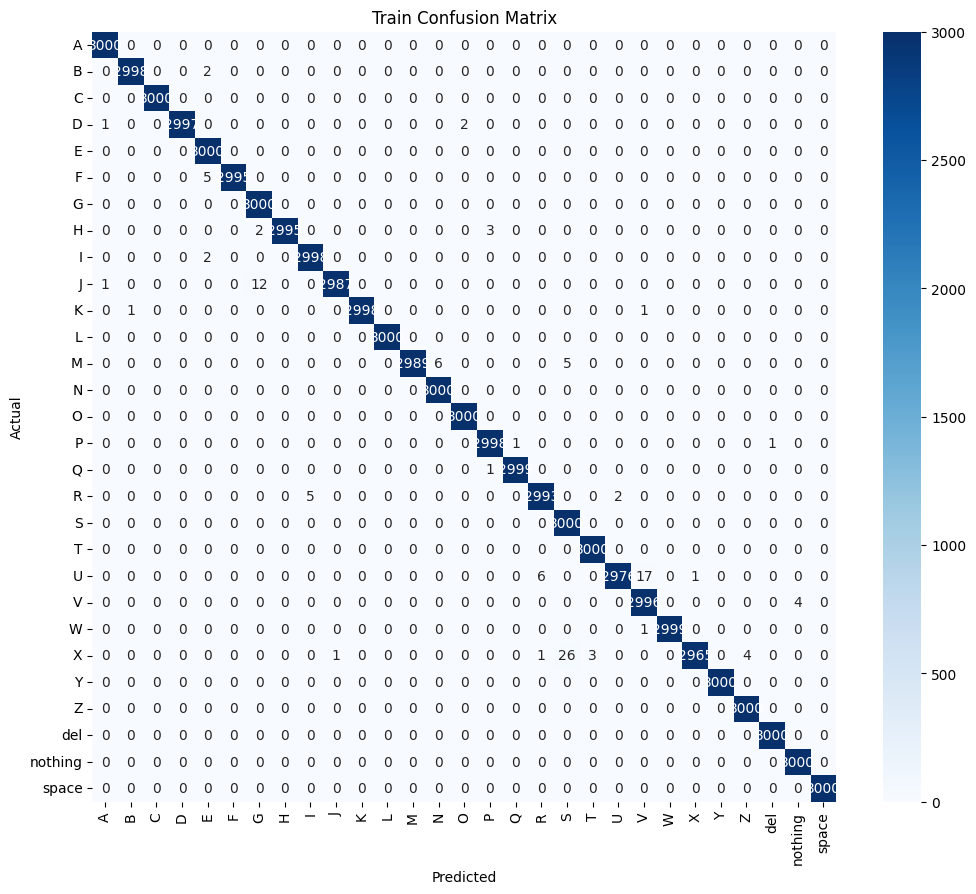

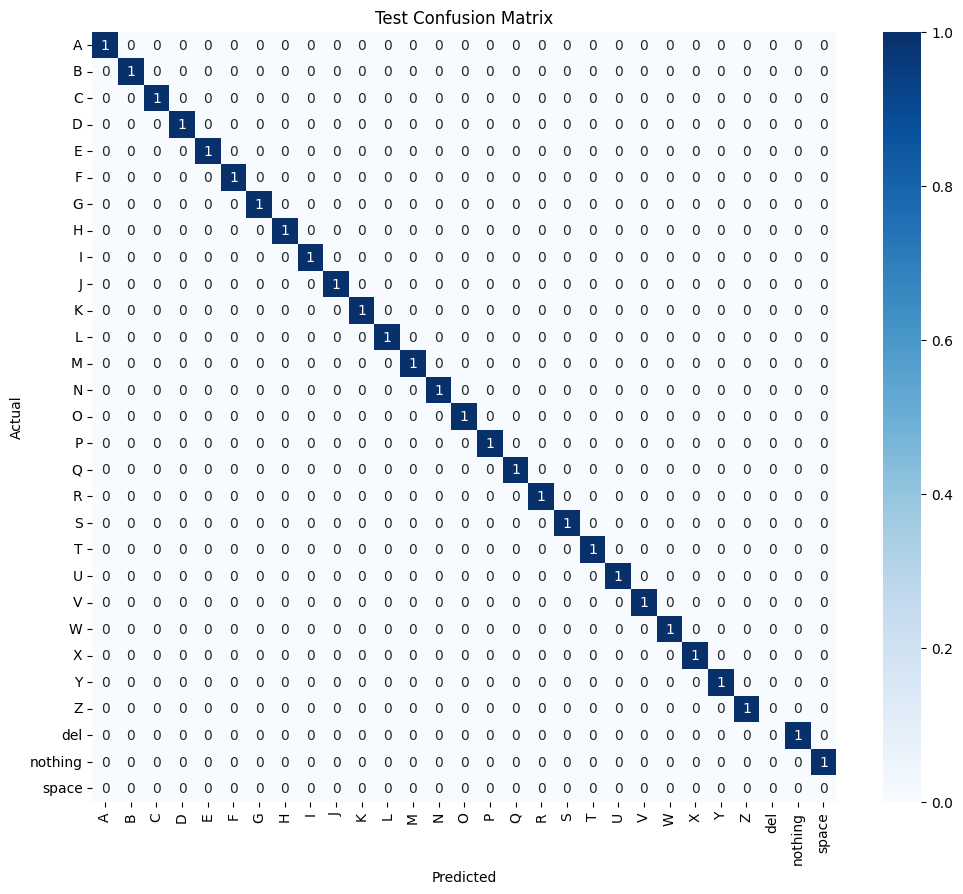

In [8]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, loader, class_names, device, title="Confusion Matrix"):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# ======================
# Example usage
# ======================
# Make sure your model is trained and on the correct device
class_names = train_dataset.classes  # automatically detected by ImageFolder

# Confusion matrix for TRAIN set
plot_confusion_matrix(model, train_loader, class_names, DEVICE, title="Train Confusion Matrix")

# Confusion matrix for TEST set
plot_confusion_matrix(model, test_loader, class_names, DEVICE, title="Test Confusion Matrix")


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, loader, class_names, device, title="Confusion Matrix", normalize=True):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate accuracy
    correct = np.trace(cm)
    total = np.sum(cm)
    accuracy = 100 * correct / total
    print(f"{title} Accuracy: {accuracy:.2f}%")
    
    # Normalize if requested
    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm_norm = cm

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title} (Accuracy: {accuracy:.2f}%)")
    plt.show()

# ======================
# Example usage
# ======================
class_names = train_dataset.classes  # automatically detected by ImageFolder

# Confusion matrix for TRAIN set (normalized)
plot_confusion_matrix(model, train_loader, class_names, DEVICE, title="Train Confusion Matrix", normalize=True)

# Confusion matrix for TEST set (normalized)
plot_confusion_matrix(model, test_loader, class_names, DEVICE, title="Test Confusion Matrix", normalize=True)
